In [1]:
import os
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})

In [2]:
%load_ext autoreload
%autoreload 2

import experiments_utils

In [3]:
STORE_DATA_FOLDER = 'experiments/concrete_strength/'

def load_exported_data(name):
    return joblib.load(os.path.join(STORE_DATA_FOLDER, name))

folds_data = load_exported_data('folds.bz2')

# Semifactual explanations

In [4]:
sf_regression_rsmall_raw = load_exported_data('sf_regression_rsmall@sgower.bz2')
sf_regression_rsmall = pd.DataFrame(experiments_utils.extract_anchor_explanations(sf_regression_rsmall_raw))

In [5]:
sf_regression_rbig_raw = load_exported_data('sf_regression_rbig@sgower.bz2')
sf_regression_rbig = pd.DataFrame(experiments_utils.extract_anchor_explanations(sf_regression_rbig_raw))

In [6]:
sf_small_df = pd.DataFrame(sf_regression_rsmall.copy())
sf_small_df.set_index('sample_idx', inplace=True)

sf_rbig_df = pd.DataFrame(sf_regression_rbig.copy())
sf_rbig_df.set_index('sample_idx', inplace=True)

In [7]:
reduced_cols = ['own_coverage', 'own_precision', 'num_conditions']

sf_small_df_reduced = sf_small_df[reduced_cols]
sf_rbig_df_reduced = sf_rbig_df[reduced_cols]

sf_small_df_reduced.columns = pd.MultiIndex.from_product([['small'], sf_small_df_reduced.columns])
sf_rbig_df_reduced.columns = pd.MultiIndex.from_product([['big'], sf_rbig_df_reduced.columns])

sf_reduced_df = pd.concat((sf_small_df_reduced, sf_rbig_df_reduced), axis=1)
sf_reduced_df['prediction'] = sf_small_df['prediction']

for percentage_col in ['own_coverage', 'own_precision']:
    for col in sf_reduced_df:
        if percentage_col in col:
            sf_reduced_df[col] = 100 * sf_reduced_df[col]
            
sf_reduced_df = sf_reduced_df.round(2)

In [8]:
reduced_cols = ['own_coverage', 'own_precision', 'num_conditions', 'prediction']

sf_small_df_reduced = sf_small_df[reduced_cols]
sf_small_df_reduced['type'] = "$sr_{5}$"
sf_rbig_df_reduced = sf_rbig_df[reduced_cols]
sf_rbig_df_reduced['type'] = "$sr_{10}$"

full = pd.concat((sf_small_df_reduced, sf_rbig_df_reduced))
full['own_coverage'] = full['own_coverage'] * 100
full['own_precision'] = full['own_precision'] * 100
full = full.rename(columns={'own_coverage': 'Coverage (%)', 'own_precision': 'Fidelity (%)', 'num_conditions': 'Nº conditions'})
full_melt = full.melt(['type', 'prediction'], value_name='value')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


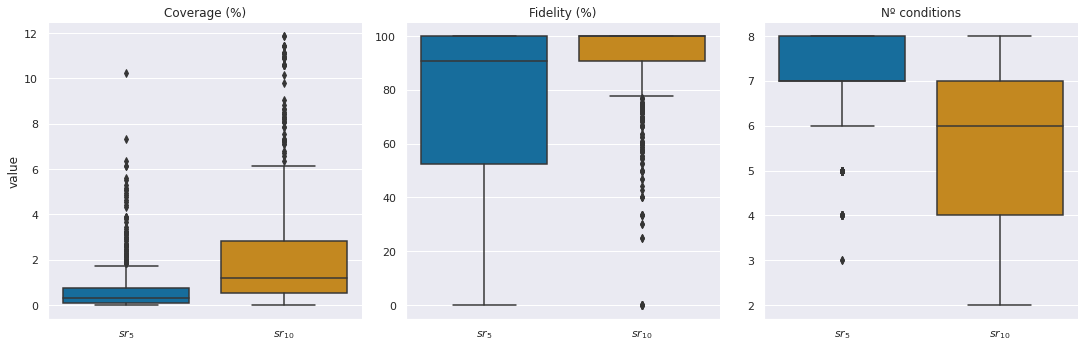

In [9]:
g = sns.catplot(
    data=full_melt, x='type', y='value',
    col='variable', kind='box', col_wrap=3, sharey=False, palette='colorblind'
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("")
g.savefig("figures/concrete_sf.png", dpi=400)

# Counterfactual explanations

In [10]:
cc_regression_small_raw = load_exported_data('cc_regression_rsmall@sgower.bz2')
cc_regression_small = pd.DataFrame(experiments_utils.extract_counterfactual_explanations(cc_regression_small_raw))

In [11]:
cc_regression_big_raw = load_exported_data('cc_regression_rbig@sgower.bz2')
cc_regression_big = pd.DataFrame(experiments_utils.extract_counterfactual_explanations(cc_regression_big_raw))

In [12]:
cc_regression_gt_raw = load_exported_data('cc_regression_gt@sgower.bz2')
cc_regression_gt = pd.DataFrame(experiments_utils.extract_counterfactual_explanations(cc_regression_gt_raw))

In [13]:
cc_regression_gt_offset_raw = load_exported_data('cc_regression_gt_offset@sgower.bz2')
cc_regression_gt_offset = pd.DataFrame(experiments_utils.extract_counterfactual_explanations(cc_regression_gt_offset_raw))

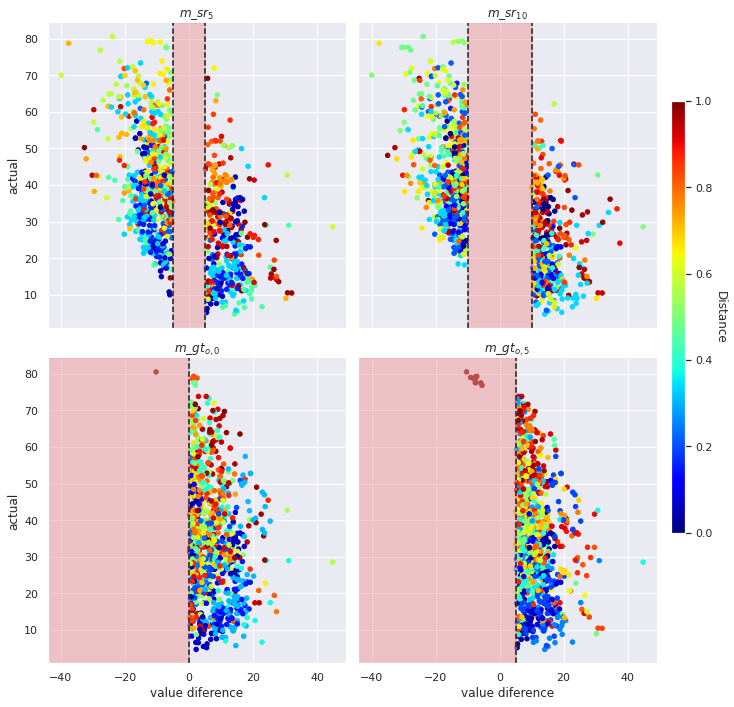

In [16]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

cc_plot_1_small = cc_regression_small.copy()
cc_plot_1_small['type'] = "$m\_sr_5$"
cc_plot_1_small['distance'] = QuantileTransformer(output_distribution='uniform').fit_transform(cc_plot_1_small['loss'].values.reshape(-1, 1)).reshape(-1)

cc_plot_1_big = cc_regression_big.copy()
cc_plot_1_big['type'] = "$m\_sr_{10}$"
cc_plot_1_big['distance'] = QuantileTransformer(output_distribution='uniform').fit_transform(cc_plot_1_big['loss'].values.reshape(-1, 1)).reshape(-1)

cc_plot_1_gt = cc_regression_gt.copy()
cc_plot_1_gt['type'] = "$m\_gt_{o,0}$"
cc_plot_1_gt['distance'] = QuantileTransformer(output_distribution='uniform').fit_transform(cc_plot_1_gt['loss'].values.reshape(-1, 1)).reshape(-1)

cc_plot_1_gt_offset = cc_regression_gt_offset.copy()
cc_plot_1_gt_offset['type'] = "$m\_gt_{o,5}$"
cc_plot_1_gt_offset['distance'] = QuantileTransformer(output_distribution='uniform').fit_transform(cc_plot_1_gt_offset['loss'].values.reshape(-1, 1)).reshape(-1)

cc_plot_1_df = pd.concat((cc_plot_1_small, cc_plot_1_big, cc_plot_1_gt, cc_plot_1_gt_offset), axis=0)
cc_plot_1_df['value diference'] = cc_plot_1_df['counterfactual_class'] - cc_plot_1_df['actual']
#cc_plot_1_df['distance'] = cc_plot_1_df['loss']

cmap = plt.get_cmap('jet')

# 
#cc_plot_1_df['distance'] = 
vmin, vmax = cc_plot_1_df['distance'].min(), cc_plot_1_df['distance'].max()

g = sns.FacetGrid(cc_plot_1_df, col='type', palette = 'jet', height=5, col_wrap=2)

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    plt.scatter(x, y, c=c, **kwargs)

cmap = plt.get_cmap('jet')
g = g.map(facet_scatter, "value diference", "actual", "distance", vmin=vmin, vmax=vmax, cmap=cmap, s=20)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)

# Draw the colorbar
cbar = g.fig.colorbar(points, cax=cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Distance', rotation=270)

# Radius lines
g.axes[0].axvline(-5, color='k', linestyle='--')
g.axes[0].axvline(5, color='k', linestyle='--')
g.axes[0].axvspan(-5, 5, color='#EF9A9A', alpha=0.5)

g.axes[1].axvline(-10, color='k', linestyle='--')
g.axes[1].axvline(10, color='k', linestyle='--')
g.axes[1].axvspan(-10, 10, color='#EF9A9A', alpha=0.5)

g.axes[2].axvline(0, color='k', linestyle='--')
x_lim_1 = list(g.axes[2].get_xlim())
g.axes[2].axvspan(x_lim_1[0], 0, color='#EF9A9A', alpha=0.5)

g.axes[3].axvline(5, color='k', linestyle='--')
g.axes[3].axvspan(g.axes[3].get_xlim()[0], 5, color='#EF9A9A', alpha=0.5)

g.axes[2].set_xlim(*x_lim_1)

# Titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.savefig("figures/concrete_cc.png", dpi=400)

# Training a DT 

In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report

In [18]:
cc_regression_gt_offset.iloc[1]['observation']

cement                332.5
blast_furnace_slag    142.5
fly_ash                 0.0
water                 228.0
superplasticizer        0.0
coarse_aggregate      932.0
fine_aggregate        594.0
age                   270.0
Name: 2, dtype: float64

In [19]:
cut_off_value = cc_regression_gt_offset['actual'].iloc[1]
cut_off_value

41.87437566024761

In [20]:
targets = cc_regression_gt_offset['actual'] <= cut_off_value
targets.value_counts()

True     702
False    328
Name: actual, dtype: int64

In [21]:
X = cc_regression_gt_offset['observation'].apply(pd.Series)
X.head(1)

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.33, random_state=42)

In [23]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [24]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.66      0.80      0.73       117
        True       0.88      0.78      0.83       223

    accuracy                           0.79       340
   macro avg       0.77      0.79      0.78       340
weighted avg       0.81      0.79      0.80       340



In [25]:
(clf.predict(X) == targets).value_counts()

True     856
False    174
Name: actual, dtype: int64

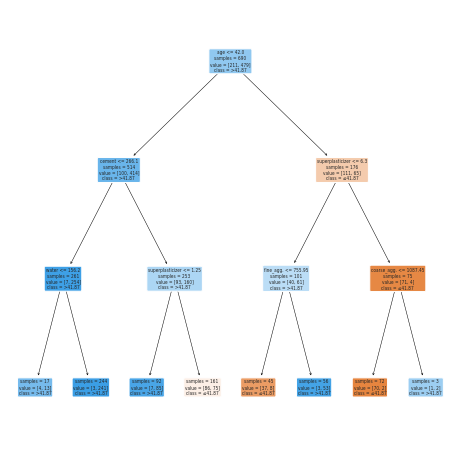

In [26]:
fn=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
cn=['setosa', 'versicolor', 'virginica']

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize=(8, 8))
out = plot_tree(clf,
               feature_names = [x.replace('aggregate', 'agg.') for x in X.columns],
               impurity=False,
               rounded=True,
                ax=axes,
               class_names=[f'≤{round(cut_off_value, 2)}', f'>{round(cut_off_value, 2)}'],
               filled = True);

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(0.5)

fig.savefig('figures/concrete_dt.jpg', dpi=400)

In [27]:
export_graphviz(clf,
                     out_file="figures/concrete_dt.dot",
               feature_names = [x.replace('aggregate', 'agg.') for x in  X.columns],
               impurity=False,
               rounded=True,
               proportion=False,
               class_names=[f'≤{round(cut_off_value, 2)}', f'>{round(cut_off_value, 2)}'],
               filled = True)

In [71]:
# apply reg samples = ([\d]+)\\nvalue = \[([\d]+), ([\d]+)\]\\n

In [70]:
!dot -Tpng -Gdpi=400 figures/concrete_dt.dot -o figures/concrete_dt_ghv.png